In [1]:
import pycrfsuite
import numpy as np
from sklearn.metrics import classification_report
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import random

In [2]:
def load_data(files):
    data, sent = [], []
    for file in files:
        with open(file, 'r',encoding='utf-8') as rf:
            for line in rf:
                if line.strip() != '':
                    # Note: the shared corpus is already tokenized
                    #print(line.strip())
                    #print("by")
                    sent.append(line.strip().split('\t'))
                else:
                    if len(sent) > 0:
                        #print(len(sent))
                        data.append(sent)
                        sent = []
    return data

sents = load_data(['data/FB_HI_EN_CR.txt', 'data/TWT_HI_EN_CR.txt', 'data/WA_HI_EN_CR.txt','data/FB_BN_EN_CR.txt', 'data/TWT_BN_EN_CR.txt', 'data/WA_BN_EN_CR.txt','data/FB_TE_EN_CR.txt', 'data/TWT_TE_EN_CR.txt', 'data/WA_TE_EN_CR.txt'])

In [3]:
random.seed(7)
random.shuffle(sents)
train_sents = sents[:int(0.8*len(sents))]
valid_sents = sents[int(0.8*len(sents)):]
print("# Train sentences: %d" % (len(train_sents)))
print("# Validation sentences: %d" % (len(valid_sents)))

# Train sentences: 4186
# Validation sentences: 1047


In [4]:
def word2features(sent, k):
    word = sent[k][0]
    features = [
        'token=%s' % (word)
    ]
    # extracting n-grams, for n=1 to 5
    for i in range(1,6):
        # if the value of n is greater than the word length, we exit the loop
        if i > len(word):
            break
        character_features = [word[j:j+i] for j in range(len(word)-i+1)]
        features.extend([
            # is count of individual n-grams important? is the order important?
            "char-%d-gram=%s" % (i, ' '.join(list(set(character_features))))
        ])
    if k == 0:
        # first word in the sentence
        features.append('BOS')
    else:
        features.extend([
            "-1:word=%s" % (sent[k-1][0])
        ])
    if i == len(sent):
        # last word in the sentence         
        features.append('EOS')
 
    return features
        
def sent2features(sent):
    # generating features for all the words/tokens in a sentence `sent`    
    return [word2features(sent, i) for i in range(len(sent))]

def sent2langs(sent):
    return [language_label for token, language_label, pos_tag in sent]

def sent2pos(sent):
    return [pos_tag for token, language_label, pos_tag in sent]

def sent2tokens(sent):
    return [token for token, language_label, pos_tag in sent]

In [5]:
X_train = [sent2features(sent) for sent in train_sents]
y_train = [sent2pos(sent) for sent in train_sents]

X_test = [sent2features(sent) for sent in valid_sents]
y_test = [sent2pos(sent) for sent in valid_sents]
print(X_train[0])

[['token=RT', 'char-1-gram=T R', 'char-2-gram=RT', 'BOS'], ['token=@ThatSalmanFan', 'char-1-gram=F n l @ h a S m t T', 'char-2-gram=lm tS an Sa al nF at ma ha Th Fa @T', 'char-3-gram=atS Tha hat tSa Sal anF Fan man lma @Th alm nFa', 'char-4-gram=tSal atSa anFa @Tha alma lman hatS nFan That manF Salm', 'char-5-gram=ThatS atSal @That lmanF manFa hatSa tSalm Salma alman anFan', '-1:word=RT'], ['token=:', 'char-1-gram=:', '-1:word=@ThatSalmanFan'], ['token=@Salman_ki_sena', 'char-1-gram=n l @ k i a S m _ s e', 'char-2-gram=na i_ lm ki en n_ @S an Sa al _k se ma _s', 'char-3-gram=ki_ @Sa _se sen _ki Sal i_s man n_k lma an_ alm ena', 'char-4-gram=an_k man_ alma lman _ki_ ki_s n_ki i_se sena _sen @Sal Salm', 'char-5-gram=lman_ _sena n_ki_ i_sen man_k Salma an_ki ki_se alman _ki_s @Salm', '-1:word=:'], ['token=mauhit', 'char-1-gram=u i h a m t', 'char-2-gram=uh au it hi ma', 'char-3-gram=uhi auh mau hit', 'char-4-gram=mauh auhi uhit', 'char-5-gram=mauhi auhit', '-1:word=@Salman_ki_sena'], ['to

In [6]:
trainer = pycrfsuite.Trainer(verbose=True)

for xseq, yseq in zip(X_train, y_train):
    print(xseq,yseq)
    print("\n")
    trainer.append(xseq, yseq)

[['token=RT', 'char-1-gram=T R', 'char-2-gram=RT', 'BOS'], ['token=@ThatSalmanFan', 'char-1-gram=F n l @ h a S m t T', 'char-2-gram=lm tS an Sa al nF at ma ha Th Fa @T', 'char-3-gram=atS Tha hat tSa Sal anF Fan man lma @Th alm nFa', 'char-4-gram=tSal atSa anFa @Tha alma lman hatS nFan That manF Salm', 'char-5-gram=ThatS atSal @That lmanF manFa hatSa tSalm Salma alman anFan', '-1:word=RT'], ['token=:', 'char-1-gram=:', '-1:word=@ThatSalmanFan'], ['token=@Salman_ki_sena', 'char-1-gram=n l @ k i a S m _ s e', 'char-2-gram=na i_ lm ki en n_ @S an Sa al _k se ma _s', 'char-3-gram=ki_ @Sa _se sen _ki Sal i_s man n_k lma an_ alm ena', 'char-4-gram=an_k man_ alma lman _ki_ ki_s n_ki i_se sena _sen @Sal Salm', 'char-5-gram=lman_ _sena n_ki_ i_sen man_k Salma an_ki ki_se alman _ki_s @Salm', '-1:word=:'], ['token=mauhit', 'char-1-gram=u i h a m t', 'char-2-gram=uh au it hi ma', 'char-3-gram=uhi auh mau hit', 'char-4-gram=mauh auhi uhit', 'char-5-gram=mauhi auhit', '-1:word=@Salman_ki_sena'], ['to

[['token=#252', 'char-1-gram=5 # 2', 'char-2-gram=52 #2 25', 'char-3-gram=252 #25', 'char-4-gram=#252', 'BOS'], ['token=:', 'char-1-gram=:', '-1:word=#252'], ['token=I', 'char-1-gram=I', '-1:word=:'], ['token=am', 'char-1-gram=m a', 'char-2-gram=am', '-1:word=I'], ['token=not', 'char-1-gram=n o t', 'char-2-gram=no ot', 'char-3-gram=not', '-1:word=am'], ['token=an', 'char-1-gram=n a', 'char-2-gram=an', '-1:word=not'], ['token=IITian', 'char-1-gram=n i a I T', 'char-2-gram=II an ia Ti IT', 'char-3-gram=ITi IIT ian Tia', 'char-4-gram=IITi ITia Tian', 'char-5-gram=ITian IITia', '-1:word=an'], ['token=but', 'char-1-gram=u b t', 'char-2-gram=ut bu', 'char-3-gram=but', '-1:word=IITian'], ['token=this', 'char-1-gram=s h i t', 'char-2-gram=is th hi', 'char-3-gram=his thi', 'char-4-gram=this', '-1:word=but'], ['token=is', 'char-1-gram=s i', 'char-2-gram=is', '-1:word=this'], ['token=for', 'char-1-gram=r f o', 'char-2-gram=or fo', 'char-3-gram=for', '-1:word=is'], ['token=a', 'char-1-gram=a', '-1

[['token=jico', 'char-1-gram=o j c i', 'char-2-gram=co ic ji', 'char-3-gram=ico jic', 'char-4-gram=jico', 'BOS'], ['token=chul', 'char-1-gram=u h l c', 'char-2-gram=ch hu ul', 'char-3-gram=hul chu', 'char-4-gram=chul', '-1:word=jico'], ['token=ki', 'char-1-gram=k i', 'char-2-gram=ki', '-1:word=chul'], ['token=arunima', 'char-1-gram=u n i a m r', 'char-2-gram=ni ar ru ma un im', 'char-3-gram=aru uni nim ima run', 'char-4-gram=arun unim nima runi', 'char-5-gram=unima runim aruni', '-1:word=ki'], ['token=moton', 'char-1-gram=m n o t', 'char-2-gram=ot mo on to', 'char-3-gram=oto ton mot', 'char-4-gram=oton moto', 'char-5-gram=moton', '-1:word=arunima'], ['token=curly', 'char-1-gram=u y l r c', 'char-2-gram=cu ly ur rl', 'char-3-gram=rly url cur', 'char-4-gram=curl urly', 'char-5-gram=curly', '-1:word=moton'], ['token=?', 'char-1-gram=?', '-1:word=curly'], ['token=?', 'char-1-gram=?', '-1:word=?']] ['G_N', 'G_N', 'G_PRP', 'G_J', 'G_N', 'G_R', 'G_X', 'G_X']


[['token=rakshasudu', 'char-1-gr

[['token=@abidifactor', 'char-1-gram=@ i d a f t r b o c', 'char-2-gram=di if or fa ab to bi id ct @a ac', 'char-3-gram=dif fac abi idi act ifa cto bid tor @ab', 'char-4-gram=idif ctor fact difa bidi ifac acto abid @abi', 'char-5-gram=bidif idifa facto ifact @abid difac actor abidi', 'BOS'], ['token=Accha', 'char-1-gram=h A c a', 'char-2-gram=cc ch Ac ha', 'char-3-gram=cch Acc cha', 'char-4-gram=ccha Acch', 'char-5-gram=Accha', '-1:word=@abidifactor'], ['token=,', 'char-1-gram=,', '-1:word=Accha'], ['token=ager', 'char-1-gram=r g a e', 'char-2-gram=ge er ag', 'char-3-gram=ger age', 'char-4-gram=ager', '-1:word=,'], ['token=jeet', 'char-1-gram=j e t', 'char-2-gram=ee je et', 'char-3-gram=jee eet', 'char-4-gram=jeet', '-1:word=ager'], ['token=jatey', 'char-1-gram=y j a t e', 'char-2-gram=at ja te ey', 'char-3-gram=jat tey ate', 'char-4-gram=jate atey', 'char-5-gram=jatey', '-1:word=jeet'], ['token=tu', 'char-1-gram=u t', 'char-2-gram=tu', '-1:word=jatey'], ['token=ap', 'char-1-gram=p a',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
trainer.set_params({
    'c1': 0.1,   # coefficient for L1 penalty
    'c2': .01,# coefficient for L2 penalty
    'max_iterations': 200,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [8]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [9]:
trainer.train('icon2019_lid.crfsuite')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 146027
Seconds required: 0.306

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 186647.246022
Feature norm: 1.000000
Error norm: 12611.215872
Active features: 145425
Line search trials: 1
Line search step: 0.000077
Seconds required for this iteration: 0.159

***** Iteration #2 *****
Loss: 160382.223979
Feature norm: 5.683859
Error norm: 35413.068975
Active features: 145350
Line search trials: 4
Line search step: 0.125000
Seconds required for this iteration: 0.306

***** Iteration #3 *****
Loss: 147115.369621
Feature norm: 4.902606
Error norm: 8125.895380
Active features: 143647
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #41 *****
Loss: 23060.447797
Feature norm: 340.108609
Error norm: 204.668418
Active features: 130904
Line search trials: 3
Line search step: 0.250000
Seconds required for this iteration: 0.235

***** Iteration #42 *****
Loss: 22987.351261
Feature norm: 341.154950
Error norm: 96.128960
Active features: 130291
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.083

***** Iteration #43 *****
Loss: 22894.702248
Feature norm: 343.267231
Error norm: 80.542032
Active features: 129425
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.084

***** Iteration #44 *****
Loss: 22837.659110
Feature norm: 344.052425
Error norm: 191.185364
Active features: 129082
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.083

***** Iteration #45 *****
Loss: 22788.643096
Feature norm: 345.178012
Error norm: 286.718501
Active features: 128861
Line search trials: 1
Line search step: 1.000

***** Iteration #81 *****
Loss: 22207.917303
Feature norm: 377.088353
Error norm: 39.184737
Active features: 116121
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.084

***** Iteration #82 *****
Loss: 22203.758292
Feature norm: 377.415528
Error norm: 47.255462
Active features: 116008
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.083

***** Iteration #83 *****
Loss: 22201.512675
Feature norm: 377.748647
Error norm: 144.581662
Active features: 115796
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.104

***** Iteration #84 *****
Loss: 22195.139865
Feature norm: 378.091333
Error norm: 86.716354
Active features: 115753
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.083

***** Iteration #85 *****
Loss: 22190.887864
Feature norm: 378.270478
Error norm: 35.305103
Active features: 115680
Line search trials: 1
Line search step: 1.00000

***** Iteration #125 *****
Loss: 22110.423722
Feature norm: 383.049975
Error norm: 25.279582
Active features: 112085
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #126 *****
Loss: 22109.519507
Feature norm: 383.082501
Error norm: 22.624825
Active features: 112022
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #127 *****
Loss: 22108.637831
Feature norm: 383.139354
Error norm: 16.704881
Active features: 111966
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #128 *****
Loss: 22108.143293
Feature norm: 383.174707
Error norm: 34.087180
Active features: 111915
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #129 *****
Loss: 22106.854402
Feature norm: 383.235031
Error norm: 18.805160
Active features: 111901
Line search trials: 1
Line search step: 1.0

***** Iteration #170 *****
Loss: 22087.552880
Feature norm: 384.811030
Error norm: 13.651295
Active features: 110688
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #171 *****
Loss: 22087.271087
Feature norm: 384.855565
Error norm: 11.338313
Active features: 110657
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #172 *****
Loss: 22087.001957
Feature norm: 384.876342
Error norm: 10.662908
Active features: 110649
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #173 *****
Loss: 22086.804663
Feature norm: 384.910219
Error norm: 22.783645
Active features: 110614
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.082

***** Iteration #174 *****
Loss: 22086.601101
Feature norm: 384.926419
Error norm: 25.426335
Active features: 110613
Line search trials: 1
Line search step: 1.0

In [10]:
tagger = pycrfsuite.Tagger()
tagger.open('icon2019_lid.crfsuite')

In [11]:
y_true = []
y_pred = []
for each in valid_sents:
    print(len(each))
    new_sent = each
    [y_pred.append(item) for item in tagger.tag(sent2features(new_sent))]
    [y_true.append(item1) for item1 in sent2pos(new_sent)]

16
13
7
18
10
10
3
17
25
5
2
22
21
17
29
34
20
8
22
9
4
9
24
76
22
2
6
1
1
10
5
14
15
1
6
22
3
17
1
3
25
9
8
4
15
4
25
6
4
8
21
9
6
3
16
24
6
8
6
13
2
4
6
8
3
9
35
26
18
3
3
6
38
9
13
1
9
10
19
18
9
5
2
6
17
9
12
4
42
3
24
1
1
4
4
10
40
4
4
70
16
17
2
17
20
27
15
14
33
6
4
20
2
16
24
5
24
6
21
14
13
26
12
4
1
6
12
14
13
7
8
22
8
33
17
5
7
7
12
11
5
19
3
63
21
6
24
41
20
226
11
17
4
7
12
30
11
7
22
2
22
5
6
10
4
4
17
28
30
16
8
1
3
22
30
16
17
8
16
6
18
29
4
2
17
17
15
6
21
46
112
15
10
17
5
22
2
22
9
11
14
18
15
3
7
16
2
10
27
12
11
15
8
3
10
23
25
29
2
2
23
21
2
14
6
11
8
16
2
31
14
21
2
16
28
9
12
6
18
19
18
3
32
3
20
7
13
22
4
11
6
8
30
6
7
21
42
6
11
13
27
15
11
5
16
14
10
4
10
37
3
11
12
62
2
6
21
13
12
3
10
23
25
5
3
1
3
19
30
14
13
25
18
16
10
3
46
5
11
13
4
11
15
5
6
3
8
15
7
1
7
2
10
1
4
18
8
18
10
8
6
20
2
19
11
8
35
7
27
23
8
8
13
22
24
4
24
12
1
3
9
23
11
12
6
20
1
9
19
4
8
5
20
5
7
4
30
4
28
23
26
7
28
27
25
1
7
29
18
13
19
5
7
12
23
7
70
10
16
11
3
20
16
3
22
16
25
1
14
1

In [12]:
print(classification_report(y_true,y_pred,digits=2))

              precision    recall  f1-score   support

           #       0.94      0.50      0.65       195
           $       0.75      0.58      0.65       166
           @       0.93      0.61      0.73       474
          CC       0.71      0.61      0.66       284
          DT       0.82      0.79      0.80       435
           E       0.96      0.78      0.86       152
         G_J       0.75      0.59      0.66       784
         G_N       0.70      0.86      0.77      5500
       G_PRP       0.74      0.73      0.74      1079
       G_PRT       0.63      0.54      0.58       465
         G_R       0.81      0.67      0.73       477
       G_SYM       0.52      0.47      0.50       108
         G_V       0.78      0.66      0.71      2239
         G_X       0.82      0.78      0.80      2780
         PSP       0.71      0.69      0.70       936
           U       0.82      0.71      0.76       124
        null       0.05      0.01      0.02        69
           ~       0.67    

In [13]:
tags=np.unique(y_true)

In [14]:
cm = confusion_matrix(y_true,y_pred)
print(cm)

[[  97    0    0    0    0    1    2   79    1    0    0    0    6    2
     1    6    0    0]
 [   2   96    0    0    0    0    3   44    2    1    0    4    3    1
     1    0    9    0]
 [   0    0  288    0    0    0    0  178    1    0    0    0    2    1
     2    2    0    0]
 [   0    0    0  174    7    0    1   10    4   17    0    1    1    7
    62    0    0    0]
 [   0    0    1    3  343    0    1   28   27    8    0    0   11   11
     2    0    0    0]
 [   0    1    0    0    0  119    0   17    1    0    0    0    2   12
     0    0    0    0]
 [   0    0    3    1    5    0  465  242    2    4   14    3   35    8
     0    1    1    0]
 [   0    2    8   10   15    1   63 4754   84   39   19   19  222  216
    42    2    4    0]
 [   1    0    0    6   21    0    8  135  786   12    6    1   19   56
    28    0    0    0]
 [   0    0    2    3    4    0    4   89   18  252   15    4   20   18
    36    0    0    0]
 [   0    0    0    0    3    0   13   77    7   1

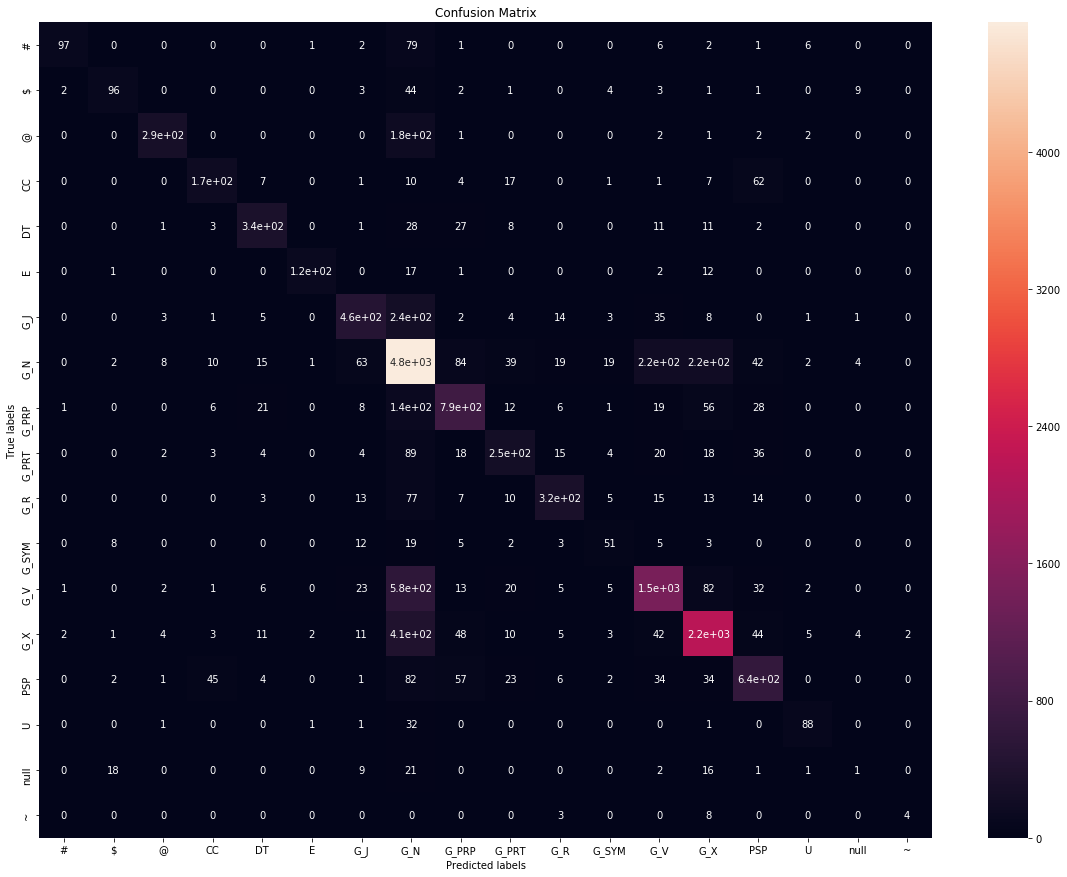

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(tags)
ax.yaxis.set_ticklabels(tags)
plt.show()

In [19]:
import sklearn_crfsuite

In [20]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=20,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [22]:
!pip install eli5
import eli5
eli5.show_weights(crf, top=30)

From \ To,#,$,@,CC,DT,E,G_J,G_N,G_PRP,G_PRT,G_R,G_SYM,G_V,G_X,PSP,U,null,~
#,2.699,-1.338,-0.353,-1.923,-1.836,0.027,-0.871,1.295,-0.509,-0.775,-0.587,-1.932,-0.438,1.302,-0.73,2.515,-0.756,-0.719
$,0.031,0.018,-0.36,0.323,-0.674,-0.054,0.0,2.623,-0.44,-0.28,0.0,-0.202,0.922,2.002,0.732,-0.075,-0.392,0.0
@,0.044,-0.898,3.146,-1.136,-0.662,-0.651,0.0,1.606,0.039,1.054,0.103,-1.188,0.86,0.472,-0.944,-0.023,-0.664,-0.891
CC,-0.782,-0.062,-0.883,-0.81,0.042,-1.475,1.141,1.849,0.56,-0.558,0.351,0.011,1.184,-0.835,-0.353,-0.946,-0.649,0.0
DT,-0.552,0.13,-0.977,-0.691,-0.756,-0.952,1.5,2.695,-0.883,-1.105,0.091,-0.082,0.992,0.192,-0.349,-0.904,-0.552,0.0
E,1.009,-0.544,-0.255,-1.493,-2.418,2.007,-0.974,1.071,-1.867,-0.709,-1.318,-1.116,-0.881,0.0,-1.47,1.265,-0.464,0.0
G_J,-0.052,0.39,-1.091,0.854,-0.213,0.855,1.587,3.488,0.77,0.836,1.28,-0.034,2.213,1.766,1.127,-0.649,-0.746,0.0
G_N,2.417,1.274,1.682,1.471,0.62,1.445,1.9,4.153,1.917,1.616,1.827,1.226,2.987,2.977,2.235,1.707,0.225,-2.648
G_PRP,-0.42,-0.007,-1.324,0.036,0.0,-0.212,1.515,2.71,1.499,0.853,1.347,0.87,2.459,1.439,0.992,-1.309,-1.439,-2.607
G_PRT,0.024,-0.896,0.0,-0.232,-0.24,0.189,1.048,1.966,0.538,1.47,0.79,-0.078,1.489,1.59,0.222,-0.429,-0.694,0.0


In [23]:
#crf.predict()

y_true1 = []
y_pred1 = []
for each1 in valid_sents:
    print(len(each1))
    new_sent1 = each1
    [y_pred1.append(item) for item in crf.predict(sent2features(new_sent1))]
    [y_true1.append(item1) for item1 in sent2pos(new_sent1)]

16
13
7
18
10
10
3
17
25
5
2
22
21
17
29
34
20
8
22
9
4
9
24
76
22
2
6
1
1
10
5
14
15
1
6
22
3
17
1
3
25
9
8
4
15
4
25
6
4
8
21
9
6
3
16
24
6
8
6
13
2
4
6
8
3
9
35
26
18
3
3
6
38
9
13
1
9
10
19
18
9
5
2
6
17
9
12
4
42
3
24
1
1
4
4
10
40
4
4
70
16
17
2
17
20
27
15
14
33
6
4
20
2
16
24
5
24
6
21
14
13
26
12
4
1
6
12
14
13
7
8
22
8
33
17
5
7
7
12
11
5
19
3
63
21
6
24
41
20
226
11
17
4
7
12
30
11
7
22
2
22
5
6
10
4
4
17
28
30
16
8
1
3
22
30
16
17
8
16
6
18
29
4
2
17
17
15
6
21
46
112
15
10
17
5
22
2
22
9
11
14
18
15
3
7
16
2
10
27
12
11
15
8
3
10
23
25
29
2
2
23
21
2
14
6
11
8
16
2
31
14
21
2
16
28
9
12
6
18
19
18
3
32
3
20
7
13
22
4
11
6
8
30
6
7
21
42
6
11
13
27
15
11
5
16
14
10
4
10
37
3
11
12
62
2
6
21
13
12
3
10
23
25
5
3
1
3
19
30
14
13
25
18
16
10
3
46
5
11
13
4
11
15
5
6
3
8
15
7
1
7
2
10
1
4
18
8
18
10
8
6
20
2
19
11
8
35
7
27
23
8
8
13
22
24
4
24
12
1
3
9
23
11
12
6
20
1
9
19
4
8
5
20
5
7
4
30
4
28
23
26
7
28
27
25
1
7
29
18
13
19
5
7
12
23
7
70
10
16
11
3
20
16
3
22
16
25
1
14
1

In [29]:
y_pred1

[['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N', 'G_N'],
 ['G_N', 'G_N', 'G_N', '

In [28]:
y_true

['@',
 'G_X',
 'G_J',
 'G_N',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'G_N',
 'PSP',
 'G_X',
 'G_X',
 'G_X',
 'null',
 '@',
 'null',
 'PSP',
 'G_R',
 'G_X',
 'G_X',
 'G_N',
 'G_N',
 'G_X',
 'G_X',
 'G_X',
 'null',
 '@',
 'G_PRT',
 'G_X',
 'G_N',
 'G_N',
 'G_V',
 'G_N',
 'G_X',
 '#',
 'G_J',
 'G_N',
 'G_V',
 'G_N',
 'G_V',
 'G_N',
 'G_N',
 'G_N',
 'G_X',
 'G_N',
 'G_V',
 'G_N',
 'G_N',
 'G_V',
 'G_X',
 'G_X',
 'G_N',
 'G_N',
 'G_N',
 'G_N',
 'PSP',
 'G_X',
 'G_X',
 'G_N',
 'G_PRP',
 'G_SYM',
 '@',
 '@',
 '@',
 'G_X',
 'G_X',
 'G_N',
 'G_N',
 'G_N',
 'G_N',
 'G_N',
 'G_N',
 'G_N',
 'G_V',
 'G_PRT',
 'G_N',
 'G_X',
 'G_V',
 'G_PRP',
 'G_N',
 'G_X',
 'G_V',
 'PSP',
 'G_N',
 'G_X',
 'G_V',
 'PSP',
 'G_N',
 'G_N',
 'PSP',
 'G_V',
 'G_X',
 '@',
 'G_N',
 'G_PRP',
 'G_N',
 'G_N',
 'G_V',
 'G_X',
 'G_PRP',
 'G_SYM',
 'G_V',
 'G_V',
 'G_X',
 'G_J',
 'G_N',
 'PSP',
 'G_J',
 'G_X',
 'PSP',
 'G_N',
 'G_N',
 'G_X',
 'G_N',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'G_X',
 'E',
 'E',
 'G_N',
 